In [86]:
import networkx as nx
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

cities = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142));

coordinates = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531));


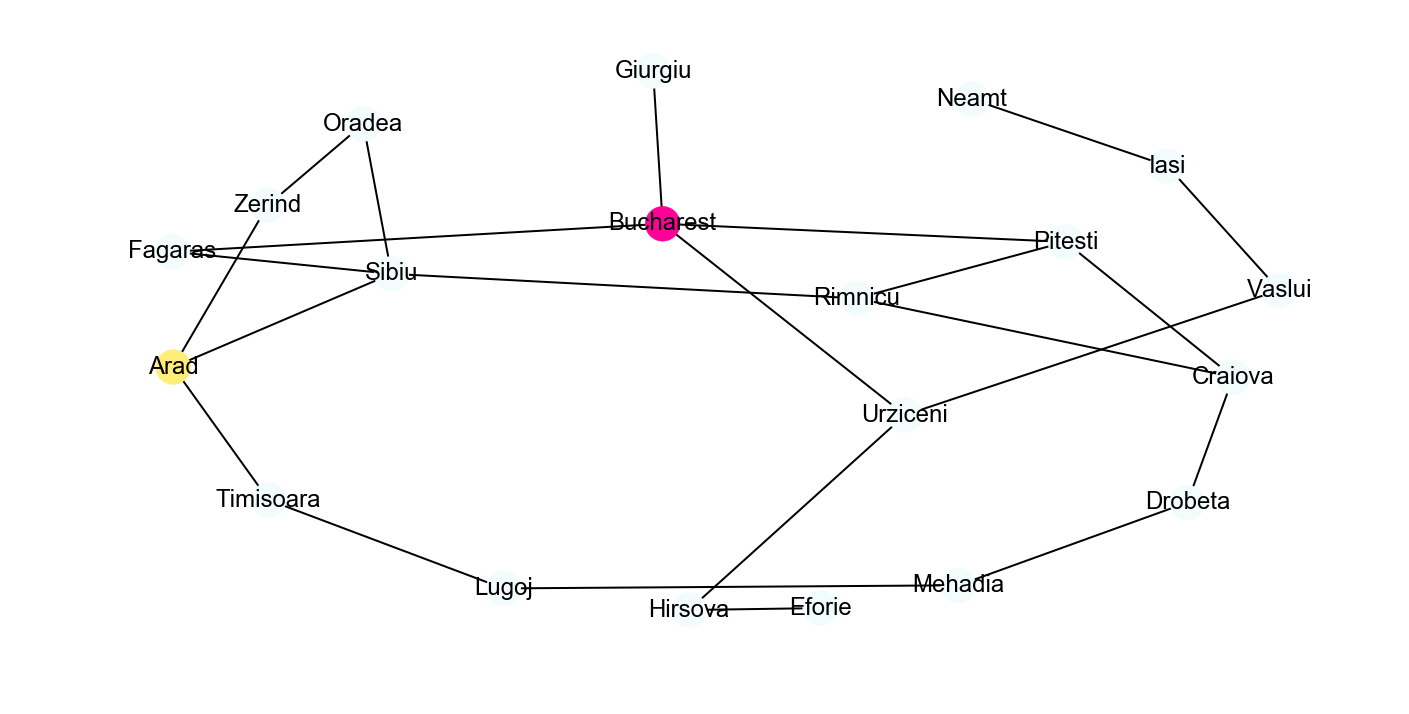

In [94]:
G = nx.Graph()

root = None;
goal = None;
cmap = {'neutral':'#f2fcfc', 'root':'#FFED79', 'goal':'#FF0099'}

def setRoot(label):
    color_map[G.nodes().index(label)] = cmap['root'];
    root = G.node[label];

def setGoal(label):
    G.node[label]['isGoal'] = True;
    color_map[G.nodes().index(label)] = cmap['goal'];
    goal = G.node[label];
    
# one color for each node
color_map = [];

for nodeName, coord in coordinates.items():
    G.add_node(nodeName, {'coord':coord, 'isGoal':False});
    color_map.append(cmap['neutral']);
for k,v in cities.items():
    for k1,v1 in v.items():
        G.add_edge(k,k1,{'cost':v1});
        
setRoot('Arad');
setGoal('Bucharest');

plt.figure(figsize=(12,6))
nx.draw_networkx(G, node_size=300, node_color = color_map, with_labels = True)
plt.axis('off')
plt.show();